# Лабораторная работы №2 "Тест Дики Фуллера"
## Импортирование библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels
from scipy import stats
from tabulate import tabulate
from itertools import product
import warnings
warnings.filterwarnings("ignore")

### Загрузка входных данных

In [81]:
source = pd.read_csv('data/nonst.csv')
X = source["pwi"].dropna()
display(X)

0        1.000000
1        3.650000
2        5.183000
3        6.426920
4        7.455227
         ...     
73    4923.938000
74    4952.902000
75    4949.282000
76    4934.800000
77    4891.353000
Name: pwi, Length: 78, dtype: float64

### Построение графика процесса

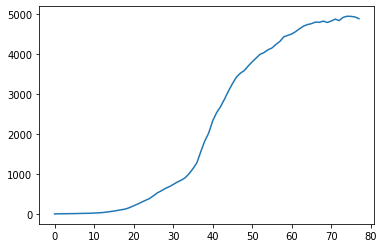

In [3]:
plt.plot(X)

### Вывод результатов применения теста Дики Фуллера

In [82]:
result = adfuller(X, maxlag=None, regression='ct', autolag='t-stat', store=False, regresults=True)
display(result)
result[3].__dict__['resols'].summary()

(-2.415800182202282,
 0.3712531830982564,
 {'1%': -4.105265484751935,
  '5%': -3.4803385352753753,
  '10%': -3.1678389485662266},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1de206906a0>)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     13.61
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           1.70e-12
Time:                        00:34:00   Log-Likelihood:                -319.46
No. Observations:                  65   AIC:                             668.9
Df Residuals:                      50   BIC:                             701.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0376      0.016     -2.416      0.019      -0.069      -0.006
x2             0.5286      0.133      3.987      0.000       0.262       0.795
x3             0.2051      0.153      1.336      0.187      -0.103       0.513
x4             0.3008      0.156      1.930      0.059      -0.012       0.614
x5            -0.2232      0.161     -1.384      0.172      -0.547       0.101
x6             0.1496      0.170      0.879      0.383      -0.192       0.491
x7            -0.0062      0.179     -0.035      0.972      -0.366       0.354
x8             0.0715      0.180      0.397      0.693      -0.290       0.433
x9            -0.0929      0.182     -0.510      0.613      -0.459       0.273
x10           -0.0356      0.184     -0.194      0.847      -0.405       0.334
x11           -0.0748      0.181     -0.414      0.681      -0.438       0.289
x12           -0.0759      0.185     -0.411      0.683      -0.447       0.295
x13            0.3643      0.157      2.318      0.025       0.049       0.680
const         -5.8366     15.285     -0.382      0.704     -36.537      24.864
x14            2.9081      1.433      2.030      0.048       0.030       5.786
==============================================================================
Omnibus:                       11.802   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.075
Skew:                           0.830   Prob(JB):                      0.00145
Kurtosis:                       4.440   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Так как для данной модели значение pVal = 0.37, что больше 0.05, то произведём анализ для разностной модели

## Разность 1го порядка

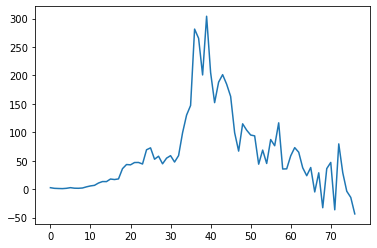

In [22]:
X_1 = np.diff(X)
plt.plot(X_1)

In [85]:
res_1ct = adfuller(X_1, maxlag=None, regression='ct', autolag='t-stat', store=False, regresults=True)
display(res_1ct)
res_1ct[3].__dict__['resols'].summary()

(-0.620017202511358,
 0.9779054401756448,
 {'1%': -4.105265484751935,
  '5%': -3.4803385352753753,
  '10%': -3.1678389485662266},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1de20bdff70>)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     1.674
Date:                Mon, 26 Apr 2021   Prob (F-statistic):             0.0959
Time:                        00:34:37   Log-Likelihood:                -323.05
No. Observations:                  65   AIC:                             674.1
Df Residuals:                      51   BIC:                             704.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0586      0.095     -0.620      0.538      -0.249       0.131
x2            -0.3566      0.154     -2.319      0.024      -0.665      -0.048
x3            -0.1408      0.155     -0.909      0.368      -0.452       0.170
x4             0.1524      0.152      1.002      0.321      -0.153       0.458
x5            -0.1063      0.152     -0.701      0.487      -0.411       0.198
x6             0.0201      0.161      0.125      0.901      -0.302       0.343
x7             0.0185      0.161      0.115      0.909      -0.304       0.341
x8             0.0633      0.161      0.393      0.696      -0.260       0.386
x9            -0.0767      0.165     -0.464      0.645      -0.408       0.255
x10           -0.1034      0.166     -0.624      0.535      -0.436       0.229
x11           -0.2000      0.164     -1.219      0.229      -0.529       0.129
x12           -0.2764      0.160     -1.727      0.090      -0.598       0.045
const         19.6617     11.568      1.700      0.095      -3.562      42.885
x13           -0.4839      0.299     -1.620      0.111      -1.083       0.116
==============================================================================
Omnibus:                       17.403   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.056
Skew:                           1.013   Prob(JB):                     3.62e-06
Kurtosis:                       5.269   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### для модели ct значение pVal = 0.97, что больше 0.05

In [86]:
res_1nс = adfuller(X_1, maxlag=None, regression='nc', autolag='t-stat', store=True, regresults=True)
display(res_1nс)
res_1nс[3].__dict__['resols'].summary()

(-1.265611902559899,
 0.18939629109363554,
 {'1%': -2.597048012760368,
  '5%': -1.9452306413344405,
  '10%': -1.6136257323972987},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1de209542b0>)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.194
Model:                            OLS   Adj. R-squared (uncentered):              0.148
Method:                 Least Squares   F-statistic:                              4.161
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                     0.00445
Time:                        00:34:41   Log-Likelihood:                         -363.67
No. Observations:                  73   AIC:                                      735.3
Df Residuals:                      69   BIC:                                      744.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0570      0.045     -1.266      0.210      -0.147       0.033
x2            -0.3033      0.121     -2.505      0.015      -0.545      -0.062
x3            -0.0650      0.126     -0.516      0.608      -0.316       0.186
x4             0.2399      0.119      2.020      0.047       0.003       0.477
==============================================================================
Omnibus:                       11.660   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.351
Skew:                           0.605   Prob(JB):                     0.000171
Kurtosis:                       5.060   Cond. No.                         3.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### для модели nc значение pVal = 0.18, что больше 0.05
### вследствие того, что у всех моделей разностни 1го порядка значение pVal > 0.05, то произведём анализ для следующей разностной модели

## Разность 2го порядка

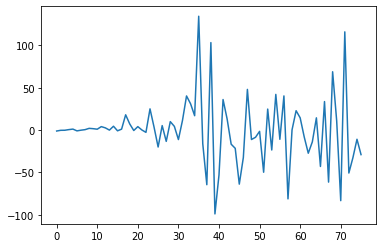

In [32]:
X_2 = np.diff(X_1)
plt.plot(X_2)

In [87]:
res_2nс = adfuller(X_2, maxlag=None, regression='nc', autolag='t-stat', store=True, regresults=True)
display(res_2nс)
res_2nс[3].__dict__['resols'].summary()

(-4.564966842038033,
 7.1587644195627795e-06,
 {'1%': -2.597048012760368,
  '5%': -1.9452306413344405,
  '10%': -1.6136257323972987},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1de20bf5c40>)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.688
Model:                            OLS   Adj. R-squared (uncentered):              0.674
Method:                 Least Squares   F-statistic:                              51.36
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    1.16e-17
Time:                        00:34:52   Log-Likelihood:                         -364.51
No. Observations:                  73   AIC:                                      735.0
Df Residuals:                      70   BIC:                                      741.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2141      0.266     -4.565      0.000      -1.744      -0.684
x2            -0.1283      0.202     -0.637      0.526      -0.530       0.274
x3            -0.2219      0.118     -1.874      0.065      -0.458       0.014
==============================================================================
Omnibus:                        8.456   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               12.199
Skew:                           0.410   Prob(JB):                      0.00224
Kurtosis:                       4.827   Cond. No.                         6.70
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### для модели nc значение pVal = 7.15e-06, что меньше 0.05